# How to perform parameter estimation with a small amount of data
**Estimate Hamiltonian model parameters using measured data and the graph-based optimization engine**

The [optimization engine](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/run_optimization) from Boulder Opal provides a large, modular collection of configuration options that allows it to be used for a range of tasks in quantum control, including estimating Hamiltonian parameters in a model using measured data. 

In this user guide, we show how this engine can be used to determine the parameters that characterize aspects of a hardware system using a small amount of measured data.
This example uses fewer than 100 data points and a single qubit.
If your problem has a large amount of data, of the order of many thousands data points, and multiple qubits, consult the user guide [How to perform parameter estimation using a large amount of measured data](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-perform-parameter-estimation-with-a-large-amount-of-data) to see how to break down the data analysed into smaller batches.
Read our [Characterizing your hardware using system identification in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/characterizing-your-hardware-using-system-identification-in-boulder-opal) topic to learn more about parameter estimation, as well as which optimization engine to use depending on your system size or the amount of measured data that you have.
A step-by-step lesson on how to perform system identification is also available in our [system identification](https://docs.q-ctrl.com/boulder-opal/tutorials/estimate-parameters-of-a-single-qubit-hamiltonian) tutorial.

## Summary workflow

### 1. Perform measurements to probe the system
In general the output of probe measurements will be estimates of various parameters, such as entries in a tomographic reconstruction of a state.
Suitable probe experiments must be crafted which give access to terms relevant to a model being captured in order to constrain the optimization search space.

### 2. Build a graph-based optimization encoding the problem
Represent the cost function to be minimized using a graph.
Define optimization parameters in the graph using `graph.optimization_variable`, and express the cost as the negative log-likelihood, as explained in the [Characterizing your hardware using system identification in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/characterizing-your-hardware-using-system-identification-in-boulder-opal) topic.
Execute the optimization using `boulderopal.run_optimization` by assigning the optimization variables to output nodes of the graph.

### 3. Estimate the precision of the results (optional)
Add the Hessian of the cost function to the output nodes in order to perform this additional analysis.
Take the inverse of the Hessian to obtain the covariance matrix.
Use the square root of this matrix to draw the confidence region of the parameter estimates, as explained in the [Characterizing your hardware using system identification in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/characterizing-your-hardware-using-system-identification-in-boulder-opal) topic

## Example: Identifying constant terms of a single-qubit Hamiltonian

In this example, we will consider how to estimate a constant Hamiltonian that rotates a single qubit.
In this case, preparing different initial states and letting the qubit evolve for different times before measuring it will reveal information about the parameters of the qubit rotation.
This setup is illustrated in the following figure.



The constant single-qubit Hamiltonian whose parameters we want to estimate takes the following form:

$$ H = \frac{1}{2} \left( \Omega_x \sigma_x + \Omega_y \sigma_y + \Omega_z \sigma_z \right). $$

The task of the optimizer in this case will be to determine these three parameters $\Omega_x$, $\Omega_y$, and $\Omega_z$.
This can be done by passing the measurement results to the optimization engine, which then finds the parameters most likely to have generated that series of points.

In this example we will rely on simulated measurement data.
We prepare these qubits in the eigenstates of $\sigma_z$, $\sigma_x$, and $\sigma_y$, and then measure the populations in eigenstates of $\sigma_y$, $\sigma_z$, and $\sigma_x$, respectively.
The optimization will then seek to minimize a cost function parameterized by $\Omega_x$, $\Omega_y$, and $\Omega_z$:
$$ C = \sum_i [P_i-p_i(\Omega_x, \Omega_y, \Omega_z)]^2 . $$
Doing so returns an estimate of the parameters that best reproduces the original dynamics of the system.

Moreover, as seen in the [Characterizing your hardware using system identification in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/characterizing-your-hardware-using-system-identification-in-boulder-opal) topic, the Hessian of this cost allows us to find the confidence region for the parameter estimates.
This confidence region represents the parameter space where the correct value of the parameters will be, with 95% probability.
We can then plot the results in three two-dimensional sections, each one representing the combination of two variables that we are estimating.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define standard state vectors.
ket_xp = np.array([[1], [1]]) / np.sqrt(2)
ket_yp = np.array([[1], [1j]]) / np.sqrt(2)
ket_zp = np.array([[1], [0]])

# Define parameters to be estimated.
actual_omegas = (2 * np.pi) * np.array([0.5e6, 1.5e6, 1.8e6])  # Hz
omega_names = [r"$\Omega_x$", r"$\Omega_y$", r"$\Omega_z$"]

In [3]:
def run_experiments(wait_times, initial_states, projector_states):
    """
    Runs a batch of simulated experiments for the given set of `wait_times`,
    `initial_states`, and `projector_states`, whose population is measured at
    the end.
    """
    # Graph for system simulation.
    graph = bo.Graph()

    # Calculate the dynamics of the system.
    hamiltonian = graph.constant_pwc(
        constant=(
            actual_omegas[0] * graph.pauli_matrix("X")
            + actual_omegas[1] * graph.pauli_matrix("Y")
            + actual_omegas[2] * graph.pauli_matrix("Z")
        )
        / 2,
        duration=max(wait_times),
    )
    unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=wait_times
    )

    # Calculate populations.
    populations = graph.reshape(
        graph.abs(
            graph.adjoint(projector_states)[:, None, ...]
            @ unitaries
            @ initial_states[:, None, ...]
        )
        ** 2,
        (len(initial_states), len(wait_times)),
    )

    # Add Gaussian error to the measurement result.
    measurement_error = graph.random.normal(
        shape=populations.shape, mean=0, standard_deviation=0.01
    )
    measurement_results = graph.add(
        populations, measurement_error, name="measurement_results"
    )

    result = bo.execute_graph(graph=graph, output_node_names="measurement_results")

    return result["output"]["measurement_results"]["value"]

In [4]:
# Range of wait times in the experiments.
duration = 500e-9  # s
time_segment_count = 20
time_resolution = duration / time_segment_count
wait_times = np.linspace(time_resolution, duration, time_segment_count)

# List of initial state preparations.
initial_states = np.array([ket_zp, ket_xp, ket_yp])

# List of states whose population will be measured at the end.
projector_states = np.array([ket_yp, ket_zp, ket_xp])

measurement_results = run_experiments(wait_times, initial_states, projector_states)

Your task (action_id="1829133") has completed.


In [5]:
# Graph for system identification. This graph encapsulates the dynamics of
# the system and uses the experimental data to estimate the parameters.
graph = bo.Graph()

# Parameters to be estimated. Frequencies whose half-periods are shorter than
# the smaller spacing between points are out of bounds.
frequency_bound = 1 / time_resolution
omegas = graph.optimization_variable(
    3, lower_bound=-frequency_bound, upper_bound=frequency_bound, name="omegas"
)

# Create Hamiltonian.
hamiltonian = graph.constant_pwc(
    constant=(
        omegas[0] * graph.pauli_matrix("X")
        + omegas[1] * graph.pauli_matrix("Y")
        + omegas[2] * graph.pauli_matrix("Z")
    )
    / 2,
    duration=duration,
)

# Calculate the projected populations.
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=wait_times
)
populations = graph.reshape(
    graph.abs(
        graph.adjoint(projector_states[:, None, ...])
        @ unitaries
        @ initial_states[:, None, ...]
    )
    ** 2,
    (len(initial_states), len(wait_times)),
)

# Calculate residual sum of squares as the cost.
cost = graph.sum((populations - measurement_results) ** 2, name="rss")

# Calculate Hessian of the negative log likelihood.
hessian_matrix = graph.hessian(cost, [omegas], name="hessian")

In [6]:
# Estimate the parameters.
result = bo.run_optimization(
    graph=graph,
    cost_node_name="rss",
    output_node_names=["omegas", "hessian"],
    optimization_count=20,
)

# Extract values from the calculation.
estimated_omegas = result["output"]["omegas"]["value"]
hessian = result["output"]["hessian"]["value"]
cost_rss = result["cost"]

Your task (action_id="1829134") has started.
Your task (action_id="1829134") has completed.


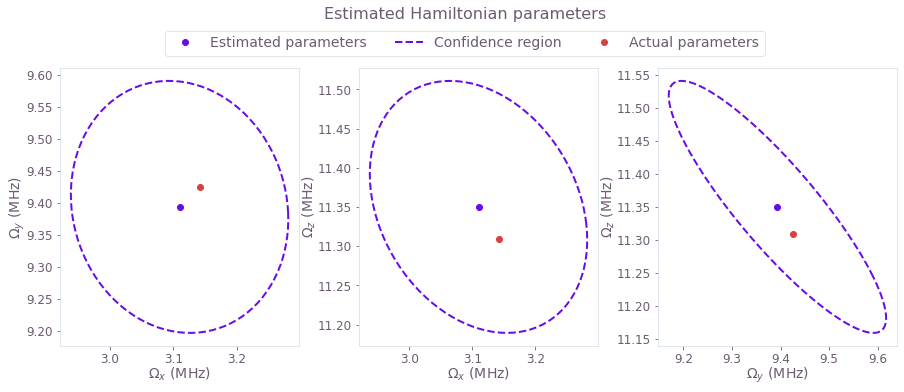

In [7]:
# Plot 95%-confidence ellipses.
measurement_count = np.prod(measurement_results.shape)
confidence_region = qv.confidence_ellipse_matrix(hessian, cost_rss, measurement_count)
qv.plot_confidence_ellipses(
    confidence_region, estimated_omegas, actual_omegas, omega_names
)
plt.suptitle("Estimated Hamiltonian parameters", y=1.05)
plt.show()